In [4]:
# Library
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from cycler import cycler
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from sklearn.ensemble import RandomForestRegressor
from transformers import AutoTokenizer, AutoModelForCausalLM
import Automation.automation as automation

from Automation.sdscm import plot_dag_from_sample_space, sample_sequences, format_sequences_as_dataframe, sample_counterfactual_sequences

In [4]:
import numpy as np
import pandas as pd
df = pd.read_csv("./data/ihdp_all_realization_cleaned.csv")
new_df = df

In [5]:
# Original llm
model_name = "Qwen/Qwen3-8B"

tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    dtype="auto",  
    device_map="auto"          
    
)
model.eval()

def call_Qwen(cur_prompt, stop=None):
    messages = [
        {"role": "user", "content": cur_prompt}
    ]
    text = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True, enable_thinking=False)

    inputs = tokenizer(text, return_tensors="pt").to(model.device)



    outputs = model.generate(
        **inputs,
        max_new_tokens=30,
        temperature=0.4,
        do_sample=False,
        eos_token_id=tokenizer.eos_token_id
    )


    response = tokenizer.decode(outputs, skip_special_tokens=True)

    return response.strip()

Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

Some parameters are on the meta device because they were offloaded to the cpu.


In [ ]:
new_df =new_df.drop("Unnamed: 0", axis = 1)
new_df =new_df.drop("realization", axis = 1)
new_df.sum()

birth_weight               normalnormalnormalnormalnormallownormallownorm...
head_circumference         normalnormalnormalnormalnormallownormallownorm...
weeks_preterm              normalnormalnormalnormalnormalhighhighhighlown...
birth_order                firstbornnormalfirstbornfirstbornfirstbornfirs...
neonatal_health_index      normallowhighnormalnormalnormalhighhighhighlow...
mother_age                 lownormallowlownormallownormallowlowhighlowlow...
firstborn                                                              34526
sex_male                                                                6316
twin                                                                   34994
smoked_cigarettes                                                      24363
drank_alcohol                                                          18159
used_drugs                                                             14816
married                                                                24098

In [7]:
#New dataset with discrete candidatews
description = """
The Infant Health and Development Program (IHDP) dataset contains detailed information about infants and their families who participated in a randomized intervention study. 
The dataset includes both demographic and socio-economic characteristics of the mothers (such as age, race, marital status, and education) as well as characteristics of the children (such as birth weight, gestational age, and health risk factors). 
In the study, some infants were randomly assigned to receive an early childhood educational intervention, while others served as a control group. 
The dataset also contains outcome variables measuring cognitive test scores at later ages, allowing researchers to study treatment effects under realistic confounding conditions. 
Several continuous variables have been discretized into categorical levels (e.g., low, mid, high) to represent grouped ranges of demographic or health-related measurements for modeling purposes.
"""
few_examples = [
    "Sentence: The mother is a young adult and is recorded as having completed a relatively low level of formal education.",
    
    "Sentence: The child received the intervention treatment and participated in the early childhood development program provided by the study.",
    
    "Sentence: The infant was born with a low birth weight, indicating an elevated level of perinatal health risk at the time of delivery."
]

candidates_set = automation.build_long_candidates_set(tokenizer,model,new_df,description=description,few_examples=few_examples)

The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


[Raw output] The infant was born with a normal birth weight, placing them within the typical range for healthy newborns. 

Okay, let's tackle this query step by step. The user wants a descriptive sentence about
[True output]The infant was born with a normal birth weight, placing them within the typical range for healthy newborns.
[Raw output] The infant was classified as having a low birth weight, which may indicate potential health risks during pregnancy or at birth. 

Okay, let's tackle this query step by step. The user wants a descriptive
[True output]The infant was classified as having a low birth weight, which may indicate potential health risks during pregnancy or at birth.
[Raw output] The infant was born with a high birth weight, which may indicate potential health advantages or complications depending on other factors. 

Okay, let's tackle this query step by step. First, I need to
[True output]The infant was born with a high birth weight, which may indicate potential health ad

In [8]:
for i in candidates_set.keys():
    print(f"{i}: {candidates_set[i]}\n")

birth_weight: ['The infant was born with a normal birth weight, placing them within the typical range for healthy newborns.', 'The infant was classified as having a low birth weight, which may indicate potential health risks during pregnancy or at birth.', 'The infant was born with a high birth weight, which may indicate potential health advantages or complications depending on other factors.']

head_circumference: ["The infant's head circumference falls within the normal range, suggesting typical developmental growth patterns during infancy.", "The infant's head circumference falls within the low category, suggesting potential developmental concerns that may be further investigated through additional assessments.", "The infant's head circumference falls within the high category, suggesting potential developmental indicators that may be associated with the study's intervention outcomes."]

weeks_preterm: ["The variable 'weeks_preterm' indicates whether the infant was born at full term 

In [9]:
import json

def save_candidates(candidates_set, path="ihdp_candidates_set.json"):
    with open(path, "w", encoding="utf-8") as f:
        json.dump(candidates_set, f, ensure_ascii=False, indent=4)
    print(f"Saved to {path}")
save_candidates(candidates_set)

Saved to ihdp_candidates_set.json


In [10]:
import importlib
import sentencepiece
import torch
import random
from transformers import PegasusForConditionalGeneration, PegasusTokenizer



# ----------------------
# Load Pegasus model
# ----------------------
model_name = 'tuner007/pegasus_paraphrase'
torch_device = 'cuda' if torch.cuda.is_available() else 'cpu'

tokenizer = PegasusTokenizer.from_pretrained(model_name)
model = PegasusForConditionalGeneration.from_pretrained(model_name).to(torch_device)


# ----------------------
# Pegasus paraphrase function
# ----------------------
def paraphrase_sentence(text, num_return_sequences=5, num_beams=5, max_length=60):

    batch = tokenizer(
        [text],
        truncation=True,
        padding='longest',
        max_length=60,
        return_tensors="pt"
    ).to(torch_device)

    outputs = model.generate(
        **batch,
        max_length=max_length,
        num_beams=num_beams,
        num_return_sequences=num_return_sequences,
        temperature=1.5
    )

    paraphrased = tokenizer.batch_decode(outputs, skip_special_tokens=True)
    return [p.strip() for p in paraphrased]


# ----------------------
# Generate N new candidate sets
# ----------------------
def generate_n_candidate_sets(candidates_set, n=5):
    """
    candidates_set: dict[str, list[str]]
        e.g. {"Survived": ["The passenger died.", "The passenger survived."], ...}
    n: how many candidate_sets you want (also = how many paraphrases per sentence)
    """

    paraphrased = {}

    for var, sentences in candidates_set.items():
        var_paras = []
        for sent in sentences:
            paras = paraphrase_sentence(sent, num_return_sequences=n)

            if len(paras) < n:
                while len(paras) < n:
                    paras.append(random.choice(paras))
            var_paras.append(paras)
        paraphrased[var] = var_paras

    all_sets = []

    for k in range(n):  
        new_set = {}
        for var, var_paras in paraphrased.items():
            new_sents = [paras[k] for paras in var_paras]
            new_set[var] = new_sents
        all_sets.append(new_set)

    return all_sets

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at tuner007/pegasus_paraphrase and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
generated_sets = generate_n_candidate_sets(candidates_set, n=3)

for i, s in enumerate(generated_sets):
    print(f"\n=== Candidate Set {i+1} ===")
    print(s)

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



=== Candidate Set 1 ===
{'birth_weight': ['The baby was born with a normal birth weight and placed within the normal range for healthy newborns.', 'The baby was classified as having a low birth weight, which may indicate potential health risks.', 'The baby was born with a high birth weight, which may indicate potential health advantages.'], 'head_circumference': ['The head circumference of an infant is within the normal range.', "Potential developmental concerns may be further investigated through additional assessments if the infant's head circumference falls within the low category.", "Potential developmental indicators that may be associated with the study's intervention outcomes can be found in the infant's head circumference."], 'weeks_preterm': ["The variable 'weeks_preterm' indicates whether the baby was born at full term or not, with normal signifying that the baby was born at full term.", "The infant was classified as high-risk due to extreme preterm birth because of the vari

In [12]:
for i, s in enumerate(generated_sets):
    save_candidates(s,path =f"ihdp_ready_{i}.json")

Saved to ihdp_ready_0.json
Saved to ihdp_ready_1.json
Saved to ihdp_ready_2.json


In [23]:
from importlib import reload
from Automation.dag_auto import sample_best_dags_no_data,fill_DAG
reload(Automation.automation)
var_names = new_df.columns.tolist()
best = sample_best_dags_no_data(
    var_names,
    n_trials=1000,
    edge_prob=0.25,
    max_parents=5,
    layered=True, n_layers=3,
    degree_prior= None,                 # try "poisson" or None
    hard_requires= None, #[("age","marital-status")],  # optional
    hard_forbids=None, #[("education","age")],        # optional
    top_vars= None,
    root_vars= None,
    important_vars = None,
    min_incident_degree = 1,
    important_role = "either",
    fail_on_impossible = True,
    seed=42,
    topk=1
)


print("Top DAG:")
print("Score:", round(best[0]["score"], 4))
print("Topo order:", best[0]["topo_order"])
print("Edges:", best[0]["edges"])
print("Parent indices (aligned to var_names):")
for i, ps in enumerate(best[0]["parent_indices"]):
    print(f"  {i:>2} {var_names[i]:<18} <- {ps}")

# ---------- Pull vars & parents from your results ----------
variables = list(var_names)                       # same order you used to run the sampler
parent_indices = best[0]["parent_indices"]        # aligned to 'variables' order

# (Optional) sanity checks
assert len(variables) == len(parent_indices), "Length mismatch between variables and parent_indices."
for j, ps in enumerate(parent_indices):
    for p in ps:
        assert 0 <= p < len(variables), f"Invalid parent index {p} for node {j} ({variables[j]})."

# Build the structure sdscm expects: list of dicts with variable_name + parent_indices
sequence_sample_space = [
    {"variable_name": variables[i], "parent_indices": parent_indices[i]}
    for i in range(len(variables))
]

parents_idx_by_name = {
    var_names[i]: list(parent_indices[i] or [])
    for i in range(len(var_names))
}

# 2) Pure index-keyed dict -> parent INDICES (compact)
parents_idx_by_child = {i: list(parent_indices[i] or []) for i in range(len(var_names))}


exogenous_by_name = {
    name: (len(parents_idx_by_name[name]) == 0)
    for name in var_names
}

Top DAG:
Score: 8.0399
Topo order: ['education', 'used_drugs', 'worked_during_pregnancy', 'neonatal_health_index', 'head_circumference', 'prenatal_care', 'birth_order', 'firstborn', 'married', 'mother_age', 'sex_male', 'drank_alcohol', 'twin', 'smoked_cigarettes', 'birth_weight', 'weeks_preterm']
Edges: [('mother_age', 'birth_weight'), ('birth_order', 'birth_weight'), ('married', 'birth_weight'), ('worked_during_pregnancy', 'birth_weight'), ('used_drugs', 'birth_weight'), ('education', 'weeks_preterm'), ('married', 'weeks_preterm'), ('neonatal_health_index', 'weeks_preterm'), ('head_circumference', 'weeks_preterm'), ('firstborn', 'weeks_preterm'), ('worked_during_pregnancy', 'mother_age'), ('neonatal_health_index', 'firstborn'), ('neonatal_health_index', 'sex_male'), ('firstborn', 'sex_male'), ('married', 'sex_male'), ('prenatal_care', 'sex_male'), ('used_drugs', 'sex_male'), ('head_circumference', 'twin'), ('birth_order', 'twin'), ('worked_during_pregnancy', 'twin'), ('prenatal_care',

In [24]:
import Automation.automation
init_framework_from_df = automation.init_framework_from_df(new_df,save_path= "ihdp_framework.json")
framework_with_candidates = automation.fill_candidate_sets("ihdp_framework.json",generated_sets[0],'ihdp_with_candidates_0.json' )
fill_DAG("ihdp_with_candidates_0.json",parents_idx_by_name, exogenous_by_name , "ihdp_complete_0.json")


Saved to ihdp_framework.json
Filled birth_weight: 3 candidates
Filled head_circumference: 3 candidates
Filled weeks_preterm: 3 candidates
Filled birth_order: 3 candidates
Filled neonatal_health_index: 3 candidates
Filled mother_age: 3 candidates
Filled firstborn: 2 candidates
Filled sex_male: 2 candidates
Filled twin: 2 candidates
Filled smoked_cigarettes: 2 candidates
Filled drank_alcohol: 2 candidates
Filled used_drugs: 2 candidates
Filled married: 2 candidates
Filled worked_during_pregnancy: 2 candidates
Filled prenatal_care: 2 candidates
Filled education: 4 candidates
Updated intervention_choices for birth_weight: [0, 1, 2]
Updated possible_outcome_choices for education: [0, 1, 2, 3]

Filled configuration saved to ihdp_with_candidates_0.json


{'description': 'No description provided.',
 'setup_sequence_sample_space': [{'variable_name': 'birth_weight',
   'candidate_set': ['The baby was born with a normal birth weight and placed within the normal range for healthy newborns.',
    'The baby was classified as having a low birth weight, which may indicate potential health risks.',
    'The baby was born with a high birth weight, which may indicate potential health advantages.'],
   'parent_indices': [5, 3, 12, 13, 11],
   'exogenous': False,
   'intervention_choice': None},
  {'variable_name': 'head_circumference',
   'candidate_set': ['The head circumference of an infant is within the normal range.',
    "Potential developmental concerns may be further investigated through additional assessments if the infant's head circumference falls within the low category.",
    "Potential developmental indicators that may be associated with the study's intervention outcomes can be found in the infant's head circumference."],
   'parent_in

In [2]:
import json

def load_candidates(path="candidates_set.json"):
    with open(path, "r", encoding="utf-8") as f:
        data = json.load(f)
    return data

In [5]:
sanple_tokenizer = AutoTokenizer.from_pretrained('Qwen/Qwen3-0.6B')
sanple_tokenizer.pad_token = sanple_tokenizer.eos_token
sanple_model = AutoModelForCausalLM.from_pretrained('Qwen/Qwen3-0.6B')

In [6]:
from Automation.new_sdscm import sample_sequences
#Load the idhdp_complete_0.json
ihdp_complete_0 = load_candidates("ihdp_complete_0.json")
ihdp_sample_space = ihdp_complete_0

np.random.seed(1)
torch.manual_seed(1)

#Sample 100
num_samples = 300
# name_of_intervention = ''
# name_of_outcome = ''
# all_covariates = [setup_dict['variable_name'] for setup_dict in ihdp_sample_space]

ihdp_samples = sample_sequences(
    model=sanple_model,
    tokenizer=sanple_tokenizer,
    sequence_sample_space=ihdp_sample_space,
    num_samples=num_samples
)


100%|██████████| 300/300 [18:08<00:00,  3.63s/it]


In [7]:
print(ihdp_samples)

[{'sampled_text': "The baby was born with a normal birth weight and placed within the normal range for healthy newborns. Potential developmental indicators that may be associated with the study's intervention outcomes can be found in the infant's head circumference. The variable 'weeks_preterm' indicates whether the baby was born at full term or not, with normal signifying that the baby was born at full term. A typical family structure with multiple siblings is suggested by the variable 'birth_order'. Significant health challenges can be seen in the infant's health index, which is categorized as high. The mother's age suggests she may be younger than average compared to other participants in the study. A value of 1 indicates that the infant is the first child in the family. The variable 'sex_male' indicates that the individual is female, as the value 0 corresponds to females in this dataset. A value of 1 means that the infant is a twin. The mother reported smoking during her pregnancie

In [8]:
from Automation.new_sdscm_2 import format_sequences_as_dataframe
from Automation.new_sdscm_2 import format_multiple_samples_as_dataframe,compare_variables_across_files,visualize_variable_comparison
name_of_intervention="birth_weight"
name_of_outcome ="twin"
all_covariates = [setup_dict['variable_name'] for setup_dict in  ihdp_complete_0["setup_sequence_sample_space"]]

df_samples_ihdp = format_sequences_as_dataframe(
    sequences=ihdp_samples,
    name_of_intervention=name_of_intervention,
    name_of_outcome=name_of_outcome,
    save_logprobs=True
)
with pd.option_context('display.max_colwidth', None):
    display(df_samples_ihdp[['sampled_text']])
    display(df_samples_ihdp[all_covariates])


,sampled_text
0,"The baby was born with a normal birth weight and placed within the normal range for healthy newborns. Potential developmental indicators that may be associated with the study's intervention outcomes can be found in the infant's head circumference. The variable 'weeks_preterm' indicates whether the baby was born at full term or not, with normal signifying that the baby was born at full term. A typical family structure with multiple siblings is suggested by the variable 'birth_order'. Significant health challenges can be seen in the infant's health index, which is categorized as high. The mother's age suggests she may be younger than average compared to other participants in the study. A value of 1 indicates that the infant is the first child in the family. The variable 'sex_male' indicates that the individual is female, as the value 0 corresponds to females in this dataset. A value of 1 means that the infant is a twin. The mother reported smoking during her pregnancies, which may indicate health risks for the baby. Fetal development and child outcomes may be influenced by the mother's consumption of alcohol. Fetal development and long-term health outcomes may be affected by the mother's use of drugs. The mother is not currently married and this may affect her access to social support networks and healthcare resources. The mother did not work during her pregnancies, which may affect her access to resources and healthcare. The child's long-term health outcomes may be influenced by the care the mother received during her pregnancies. The high school dropout level of the mother may indicate limited access to higher education opportunities."
1,"The baby was born with a normal birth weight and placed within the normal range for healthy newborns. Potential developmental indicators that may be associated with the study's intervention outcomes can be found in the infant's head circumference. The infant was classified as high-risk due to extreme preterm birth because of the variable 'weeks_preterm'. The variable 'birth_order' indicates that the infant is the third or higher order child within the family, which may have an effect on the development of the child. The infant's health status was within normal limits and there were no immediate health concerns. The mother's age suggests she may be younger than average compared to other participants in the study. The value of the variable 'firstborn' indicates if the infant is the first child in the family or not. The variable 'sex_male' indicates that the individual is female, as the value 0 corresponds to females in this dataset. A value of 1 means that the infant is a twin. The mother did not smoke cigarettes while she was pregnant. The mother did not report consuming alcohol during her pregnancies, as indicated by the value '0' for the variable 'drank_alcohol'. Fetal development and long-term health outcomes may be affected by the mother's use of drugs. The mother is not currently married and this may affect her access to social support networks and healthcare resources. The mother worked during her pregnancies and is categorized as having engaged in employment activities throughout the period. Fetal development and long-term health outcomes may be impacted by the mother not receiving adequate prenatal care. The mother did not graduate from college, but she did complete some college work."
2,"The baby was born with a normal birth weight and placed within the normal range for healthy newborns. The head circumference of an infant is within the normal range. The variable 'weeks_preterm' indicates whether the baby was born at full term or not, with normal signifying that the baby was born at full term. The firstborn child within the family may have an influence on resource allocation dynamics. The infant's health status was within normal limits and there were no immediate health concerns. The mother's age is within the normal range and she is participating in the study. A valu

,birth_weight,head_circumference,weeks_preterm,birth_order,neonatal_health_index,mother_age,firstborn,sex_male,twin,smoked_cigarettes,drank_alcohol,used_drugs,married,worked_during_pregnancy,prenatal_care,education
0,0,2,0,1,2,0,0,0,0,1,0,1,0,1,1,3
1,0,2,1,2,0,0,1,0,0,0,1,1,0,0,0,1
2,0,0,0,0,0,1,0,1,0,1,1,1,1,1,0,2
3,0,0,0,1,1,0,1,0,1,1,1,0,0,1,1,3
4,0,2,1,0,2,1,0,1,1,1,0,1,1,1,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,0,0,2,1,1,1,0,1,1,0,1,1,0,1,1,1
296,2,2,0,1,2,0,0,1,1,1,1,0,1,1,1,2
297,0,2,2,2,2,1,0,1,0,1,1,1,0,1,1,3
298,2,0,0,2,0,2,1,1,0,0,1,0,1,1,1,3


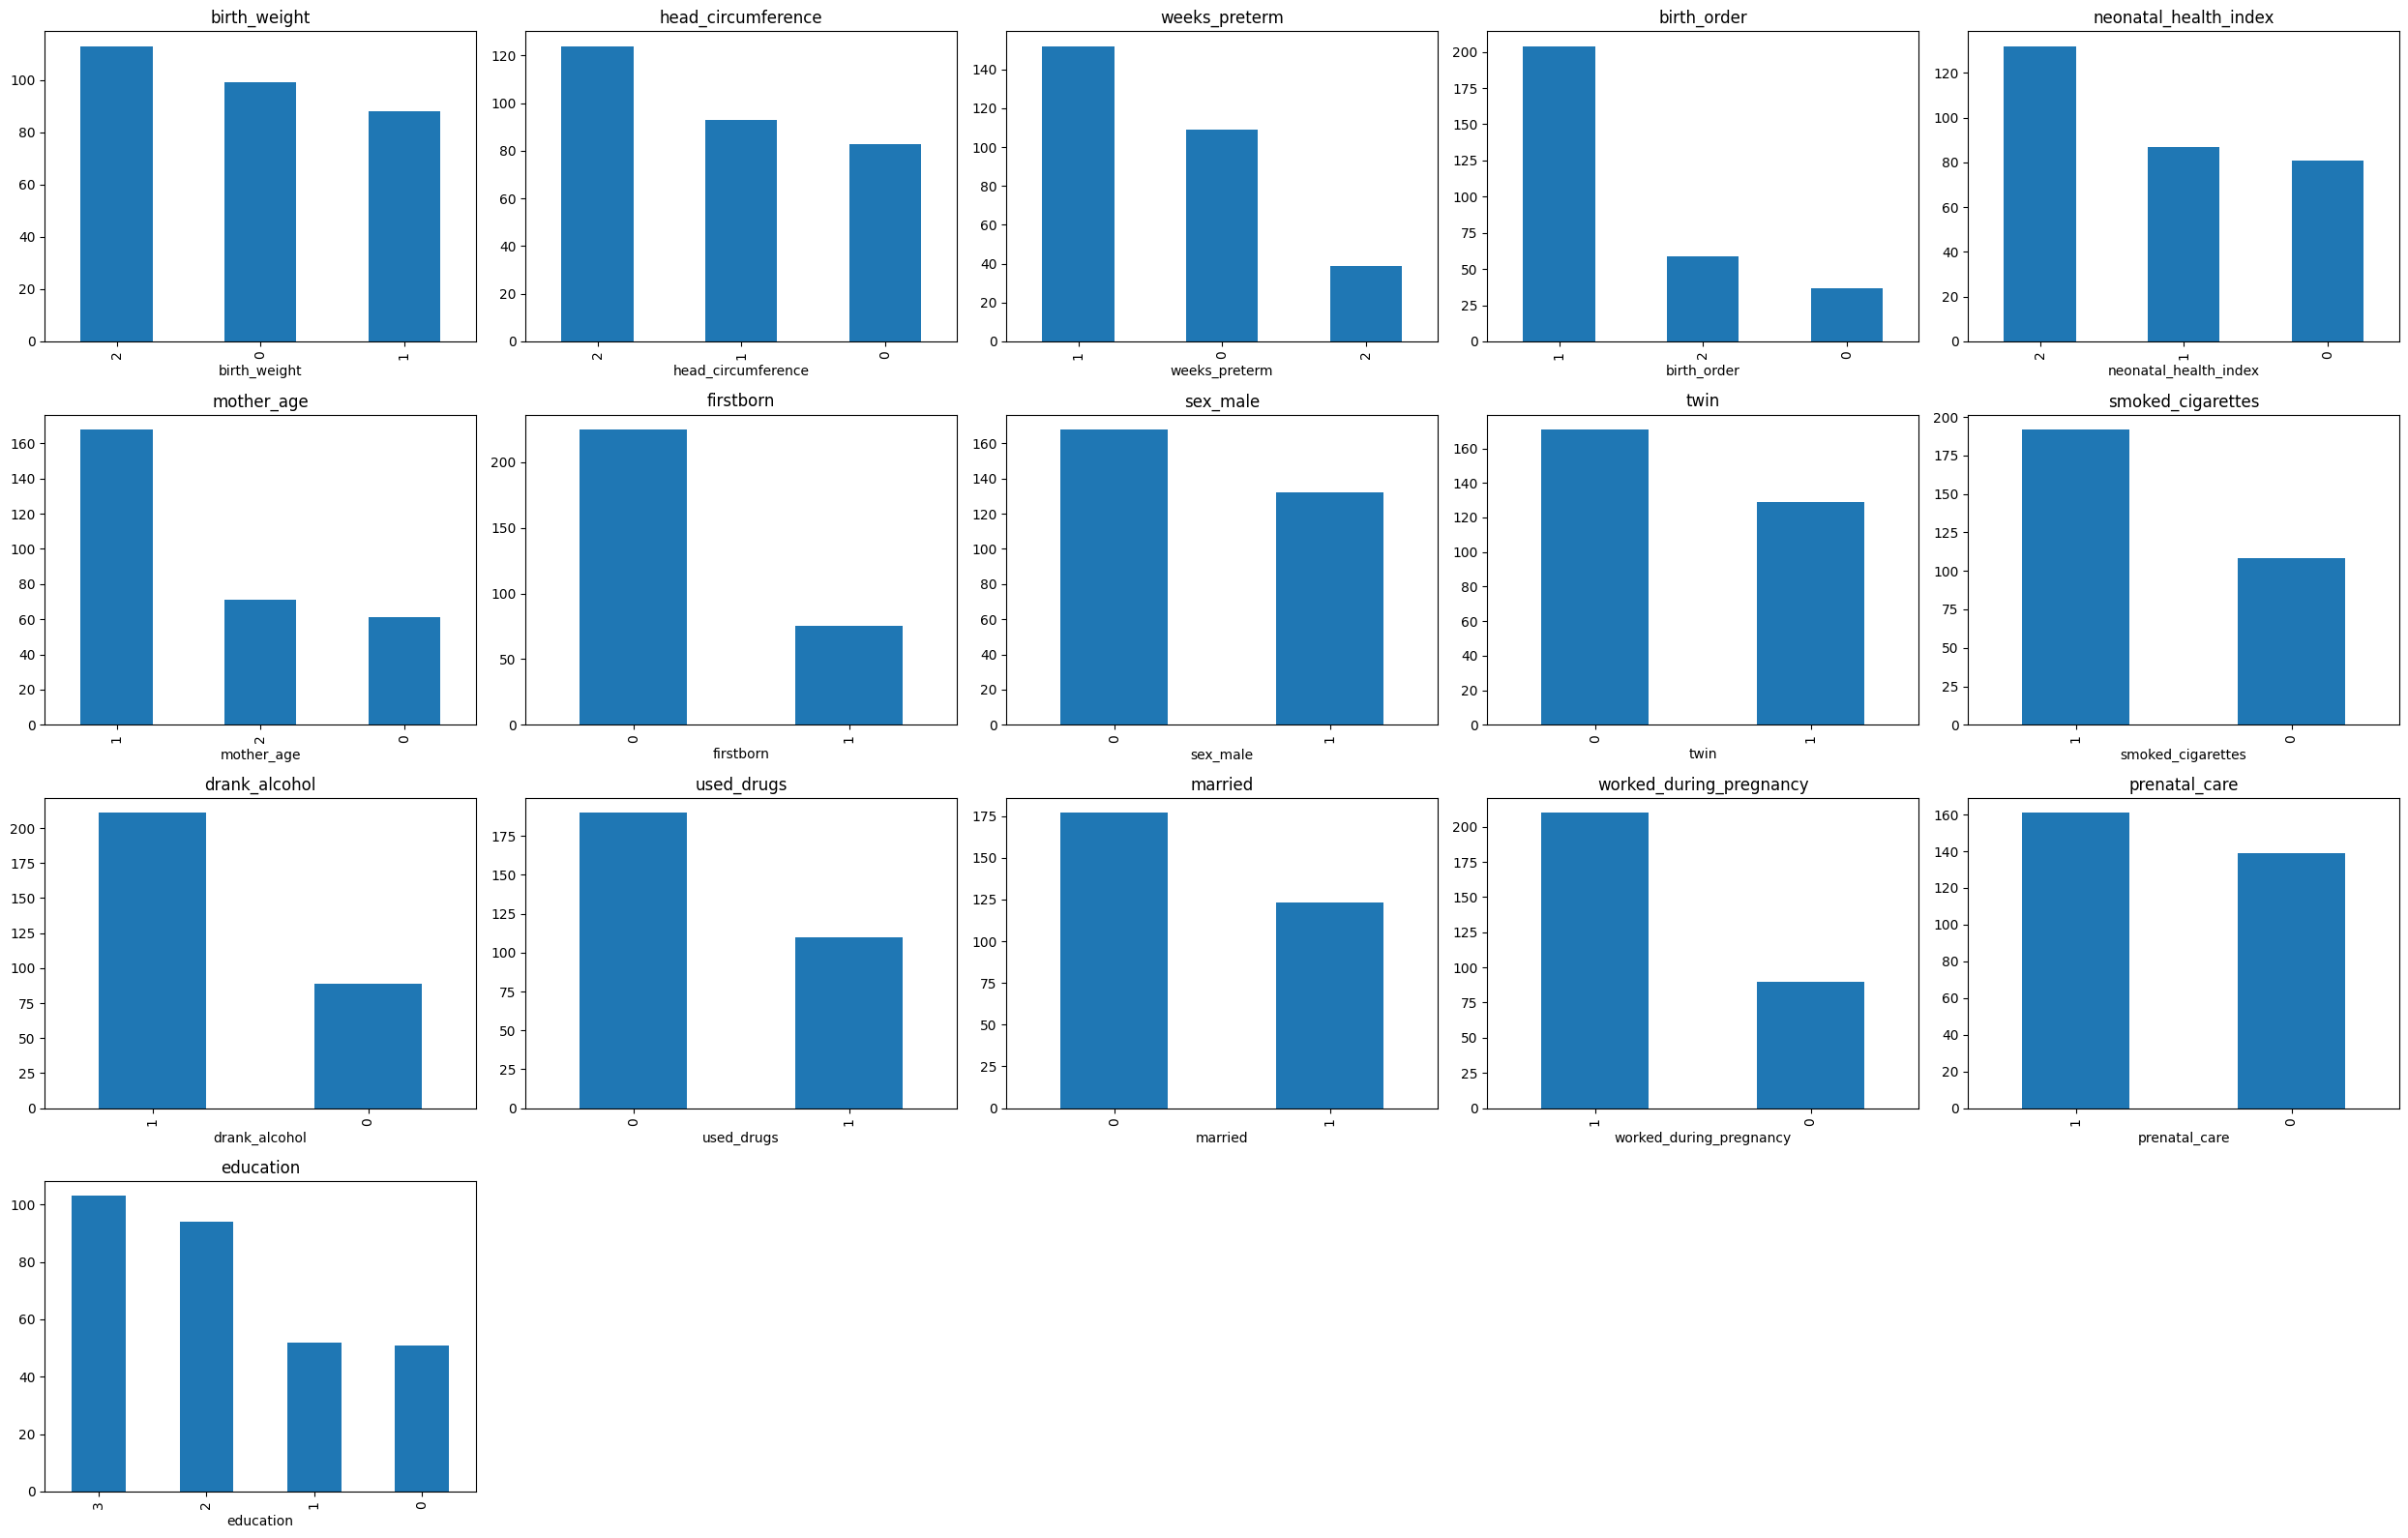

In [10]:
import matplotlib.pyplot as plt
import pandas as pd
import math

df = df_samples_ihdp[all_covariates]

cols_to_plot = [col for col in df.columns if df[col].dtype != 'object']
num_cols = len(cols_to_plot)


rows = math.ceil(num_cols / 5)
cols = 5

fig, axes = plt.subplots(rows, cols, figsize=(5*5, 4*rows))
axes = axes.flatten()  

for i, col in enumerate(cols_to_plot):
    ax = axes[i]
    unique_vals = df[col].nunique()
    
    if unique_vals < 10:  
        df[col].value_counts().plot(kind='bar', ax=ax)
        ax.set_title(f"{col}")
    else:
        df[col].plot(kind='hist', bins=20, ax=ax)
        ax.set_title(f"{col}")

for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()
